# Modelling 

* Feature Engineering
* Feature Selection -  Using Information Value (IV) technique 
* Modelling - Use the main ML algorithms 
* SHAP values of the models
* Creating the Bins of the winning model

# 1) Packages

In [1]:
!pip install shap --quiet

In [1]:
#Basic Packages
import pandas as pd
import numpy as np
import sys
import os
import pickle
import matplotlib
import matplotlib.pyplot as plt 
import shap
import seaborn as sns

#Sklearn
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

#Feature Engine
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.selection import SmartCorrelatedSelection

#Others
from scipy.stats import ks_2samp
from optbinning import OptimalBinning
from category_encoders import TargetEncoder

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(CVXPY) Feb 06 02:08:46 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 06 02:08:46 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# 'src' folder path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))

# verify the path
print("Caminho para a pasta 'src':", project_root)

# add to the sys.path
sys.path.append(project_root)

Caminho para a pasta 'src': c:\Users\lucas\OneDrive\Área de Trabalho\Data Science Projects\credit_scoring_project\src


In [3]:
import data_load as dl 
import preprocess as pipe_model
import eval as eval

# 2) Dataset

In [4]:
df = pd.read_csv('../data/df_transformed_new.csv')
df.head(2)

,Unnamed: 0.1,Unnamed: 0,id,customer_id,month,name,age,ssn,occupation,annual_income,...,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,target,credit_history_year
0,0,0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,...,NaN,809.98,26.82262,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,0,22
1,1,1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,...,Good,809.98,31.94496,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,0,-1


In [5]:
del df['Unnamed: 0.1']
del df['Unnamed: 0']

In [6]:
df.shape

(46826, 28)

In [7]:
df_train, df_oos = dl.split_data(df, 0.2)

Shape Dataset Train:37460
Shape Dataset OOS:9366


# 3) Feature Engineering

-realizar a categorização na mão das features do tipo object...

In [8]:
# Filtering only the object columns
object_columns = df.select_dtypes(include=['object']).columns

# Creation of the list with columns and the object counts
unique_counts = [(col, df[col].nunique()) for col in object_columns]

# Create the dataset
resultado = pd.DataFrame(unique_counts, columns=['Coluna', 'Valores Únicos'])
resultado

,Coluna,Valores Únicos
0,id,46826
1,customer_id,8692
2,month,8
3,name,7445
4,ssn,8673
5,occupation,15
6,type_of_loan,4785
7,credit_mix,3
8,payment_of_min_amount,3
9,payment_behaviour,6


`id`, `customer_id`, `name` and `ssn` are features that aren't needed for the model. The `type_of_loan` needs a better treatment

In [9]:
df['type_of_loan'].value_counts().head(10)

type_of_loan
Not Specified                      564
Student Loan                       506
Payday Loan                        505
Mortgage Loan                      497
Personal Loan                      489
Credit-Builder Loan                481
Auto Loan                          463
Debt Consolidation Loan            449
Home Equity Loan                   449
Personal Loan, and Student Loan    168
Name: count, dtype: int64

The top 9 values corresponds to 92% of the feature. So I will change the feature to only just 10 different values, and the 10th it's goin to be the other ones

In [10]:
# The mapping with the top 9 values
mapping = {
    'Not Specified': 0,
    'Student Loan': 1,
    'Payday Loan': 2,
    'Mortgage Loan': 3,
    'Personal Loan': 4,
    'Credit-Builder Loan': 5,
    'Auto Loan': 6,
    'Debt Consolidation Loan': 7,
    'Home Equity Loan': 8,
    'Personal Loan, and Student Loan': 9
}

# Replacement of the values in mapping
df_train['type_of_loan'] = df_train['type_of_loan'].replace(mapping)
df_oos['type_of_loan'] = df_oos['type_of_loan'].replace(mapping)

# Replace the other values for 10
df_train['type_of_loan'] = df_train['type_of_loan'].apply(lambda x: x if isinstance(x, int) else 10)
df_oos['type_of_loan'] = df_oos['type_of_loan'].apply(lambda x: x if isinstance(x, int) else 10)

In [11]:
df_train['type_of_loan'].value_counts()

type_of_loan
10    33782
0       463
2       415
1       410
4       398
5       396
3       389
6       371
7       357
8       342
9       137
Name: count, dtype: int64

In [12]:
df_oos['type_of_loan'].value_counts()

type_of_loan
10    8473
3      108
8      107
0      101
1       96
6       92
7       92
4       91
2       90
5       85
9       31
Name: count, dtype: int64

In [13]:
X_train = df_train.drop('target', axis = 1)
y_train = df_train['target']

X_oos = df_oos.drop('target', axis = 1)
y_oos = df_oos['target']

Using Target encoder in category features

In [14]:
#Creating the new dfs
df_train_te = df_train.copy()
df_oos_te = df_oos.copy()

# cat columns
cat_columns = ['occupation','type_of_loan','credit_mix','payment_of_min_amount','payment_behaviour']

# Target
target_train = df_train_te['target']
target_test = df_oos_te['target']

# Apply Target Encoding - Train
encoder = TargetEncoder(cols=cat_columns)
df_encoded_train = encoder.fit_transform(df_train_te[cat_columns], target_train)

# Apply Target Encoding - OOS
encoder = TargetEncoder(cols=cat_columns)
df_encoded_oos = encoder.fit_transform(df_oos_te[cat_columns], target_test)

# Change the original columns for the new ones
df_train_te[cat_columns] = df_encoded_train
df_oos_te[cat_columns] = df_encoded_oos

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtyp

In [31]:
df_train.groupby('payment_behaviour')['target'].mean()

payment_behaviour
High_spent_Large_value_payments     0.481272
High_spent_Medium_value_payments    0.559731
High_spent_Small_value_payments     0.594451
Low_spent_Large_value_payments      0.611529
Low_spent_Medium_value_payments     0.629492
Low_spent_Small_value_payments      0.733886
Name: target, dtype: float64

In [32]:
df_train['payment_behaviour'].value_counts(dropna=False)

payment_behaviour
Low_spent_Small_value_payments      9883
High_spent_Medium_value_payments    6387
Low_spent_Medium_value_payments     5398
High_spent_Large_value_payments     4939
High_spent_Small_value_payments     4145
Low_spent_Large_value_payments      3851
NaN                                 2857
Name: count, dtype: int64

In [24]:
df_train_te['credit_mix'].value_counts()

credit_mix
0.244559    12590
0.974594     9368
0.791324     7907
0.620013     7595
Name: count, dtype: int64

In [26]:
df_occupation = df_train[['payment_behaviour']].join(df_train_te[['payment_behaviour']], rsuffix='_encoded')

df_occupation.groupby('payment_behaviour')['payment_behaviour_encoded'].mean()

payment_behaviour
High_spent_Large_value_payments     0.481272
High_spent_Medium_value_payments    0.559731
High_spent_Small_value_payments     0.594451
Low_spent_Large_value_payments      0.611529
Low_spent_Medium_value_payments     0.629492
Low_spent_Small_value_payments      0.733886
Name: payment_behaviour_encoded, dtype: float64

In [15]:
X_train_te = df_train_te.drop('target', axis = 1)
y_train_te = df_train_te['target']

X_oos_te = df_oos_te.drop('target', axis = 1)
y_oos_te = df_oos_te['target']

# 4) Feature Selection 

## 4.1) Correlated Features

In [72]:
sel = DropCorrelatedFeatures(
    threshold=0.7,
    method='pearson',
    missing_values='ignore'
)

sel.fit(X_train)

DropCorrelatedFeatures(threshold=0.7)

In [73]:
sel.correlated_feature_sets_

[]

## 4.2) Select K Best

In [16]:
if (X_train_encoded < 0).any().any():
    print("Ainda há valores negativos no X_train_encoded!")

Ainda há valores negativos no X_train_encoded!


In [21]:
# Normalizar os dados
scaler = MinMaxScaler()

X_train_encoded = pd.get_dummies(X_train[feats])
X_train_encoded = X_train_encoded.fillna(0)
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)

# Criar e ajustar o SelectKBest
selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X_train_encoded, y_train)

# Obter os nomes das features selecionadas
selected_features = X_train_encoded.columns[selector.get_support()]
print(selected_features)

Index(['monthly_inhand_salary', 'delay_from_due_date', 'outstanding_debt',
       'credit_history_year', 'credit_mix_Bad', 'credit_mix_Good',
       'credit_mix_Standard', 'payment_of_min_amount_No',
       'payment_of_min_amount_Yes',
       'payment_behaviour_Low_spent_Small_value_payments'],
      dtype='object')


## 4.3) IV

In [44]:
feats = ['occupation','annual_income', 'monthly_inhand_salary', 'num_bank_accounts','num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit','num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'payment_of_min_amount','total_emi_per_month', 'amount_invested_monthly', 'payment_behaviour','monthly_balance', 
       'credit_history_year','target']

In [58]:
df_woe = df_train[feats]

iv_woe(df_woe[feats], target = target, bins=10, show_woe=False)

,Variable,IV
0,outstanding_debt,2.942310
1,interest_rate,2.577792
2,type_of_loan,2.505778
3,delay_from_due_date,2.237900
4,credit_mix,2.183588
5,payment_of_min_amount,2.069978
6,num_credit_inquiries,1.904467
7,credit_history_year,1.775706
8,num_bank_accounts,1.703855
9,num_of_loan,1.640461


# 5) Model build

## 5.0) Testing algorithms

In [36]:
feats_exp0 = ['occupation','annual_income', 'monthly_inhand_salary', 'num_bank_accounts','num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit','num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'payment_of_min_amount','total_emi_per_month', 'amount_invested_monthly', 'payment_behaviour','monthly_balance', 
       'credit_history_year']

In [39]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train[feats_exp0], model).fit(X_train[feats_exp0], y_train)
    
    ks_train = eval.calculate_ks(X_train[feats_exp0], y_train, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos[feats_exp0], y_oos, pipe, TARGET) 
    
    print(f'Model:', model)
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

[LightGBM] [Info] Number of positive: 23175, number of negative: 14285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618660 -> initscore=0.483864
[LightGBM] [Info] Start training from score 0.483864
Model: LGBMClassifier(random_state=42)
Train KS: 0.861
OOS KS: 0.821
Model: LogisticRegression()
Train KS: 0.0
OOS KS: 0.0
Model: DecisionTreeClassifier()
Train KS: 1.0
OOS KS: 0.815
Model: RandomForestClassifier()
Train KS: 1.0
OOS KS: 0.877
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, 

* The worst algorithm is Logistic Regression, because the features aren't treated as well and I didn't use any params
* DecisionTree and RandomForest are overfitted in the train dataset
* XGBoost had a great performance in the OOS dataset, but the train had an KS that indicates an overfit
* The LGBM are the best algorithm, avoiding the overfit and had a great performance in OOS dataset

## 5.1) Exp 1 - All features

In [60]:
feats_exp1 = ['occupation','annual_income', 'monthly_inhand_salary', 'num_bank_accounts','num_credit_card', 'interest_rate', 'num_of_loan', 'type_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit','num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'payment_of_min_amount','total_emi_per_month', 'amount_invested_monthly', 'payment_behaviour','monthly_balance', 
       'credit_history_year']

In [65]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42)]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train[feats_exp1], model).fit(X_train[feats_exp1], y_train)
    
    ks_train = eval.calculate_ks(X_train[feats_exp1], y_train, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos[feats_exp1], y_oos, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

[LightGBM] [Info] Number of positive: 23175, number of negative: 14285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3775
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618660 -> initscore=0.483864
[LightGBM] [Info] Start training from score 0.483864
Train KS: 0.858
OOS KS: 0.815


## 5.2) Exp 2 - K Best

In [74]:
feats_exp2 = ['monthly_inhand_salary', 'delay_from_due_date', 'outstanding_debt',
              'credit_history_year', 'credit_mix', 'payment_of_min_amount',
              'payment_behaviour']

In [75]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42)]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train[feats_exp2], model).fit(X_train[feats_exp2], y_train)
    
    ks_train = eval.calculate_ks(X_train[feats_exp2], y_train, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos[feats_exp2], y_oos, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

[LightGBM] [Info] Number of positive: 23175, number of negative: 14285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618660 -> initscore=0.483864
[LightGBM] [Info] Start training from score 0.483864
Train KS: 0.801
OOS KS: 0.774


## 5.3) Exp 3 - IV

In [21]:
feats_exp3 = ['outstanding_debt','interest_rate','type_of_loan','delay_from_due_date','credit_mix','payment_of_min_amount','num_credit_inquiries',
              'credit_history_year','num_bank_accounts','num_of_loan','num_credit_card']

In [26]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42)]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train[feats_exp3], model).fit(X_train[feats_exp3], y_train)
    
    ks_train = eval.calculate_ks(X_train[feats_exp3], y_train, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos[feats_exp3], y_oos, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

[LightGBM] [Info] Number of positive: 23175, number of negative: 14285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618660 -> initscore=0.483864
[LightGBM] [Info] Start training from score 0.483864
Train KS: 0.832
OOS KS: 0.796


In [27]:
feature_importances = pipe.named_steps['estimator'].feature_importances_

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out(X_train[feats_exp3].columns)

transformed_feature_names = []

for var in feature_names:
    new_var_name = var[5:]
    transformed_feature_names.append(new_var_name)

In [32]:
explainer = shap.TreeExplainer(model)

shap_values_train = explainer.shap_values(pd.DataFrame(pipe['preprocessor'].fit_transform(X_train[feats_exp3])))

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


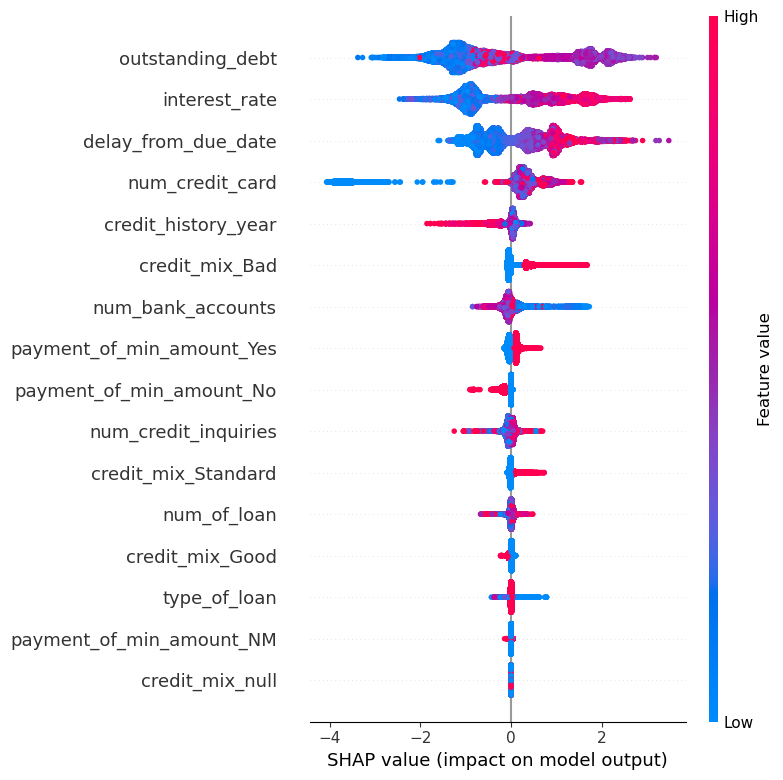

In [33]:
shap.summary_plot(shap_values_train,
                  pd.DataFrame(pipe['preprocessor'].fit_transform(X_train[feats_exp3])),
                  feature_names = transformed_feature_names,
                  max_display = 20
                  )

## 5.4) Exp 4 - IV with Target Encoder

In [48]:
feats_exp4 = ['outstanding_debt','interest_rate','type_of_loan','delay_from_due_date','credit_mix','payment_of_min_amount','num_credit_inquiries',
              'credit_history_year','num_bank_accounts','num_of_loan','num_credit_card']

In [49]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42)]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train_te[feats_exp4], model).fit(X_train_te[feats_exp4], y_train_te)
    
    ks_train = eval.calculate_ks(X_train_te[feats_exp4], y_train_te, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos_te[feats_exp4], y_oos_te, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

[LightGBM] [Info] Number of positive: 23175, number of negative: 14285
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 37460, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.618660 -> initscore=0.483864
[LightGBM] [Info] Start training from score 0.483864
Train KS: 0.831
OOS KS: 0.792


In [54]:
feature_importances = pipe.named_steps['estimator'].feature_importances_

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out(X_train_te[feats_exp4].columns)

transformed_feature_names = []

for var in feature_names:
    new_var_name = var[5:]
    transformed_feature_names.append(new_var_name)

In [55]:
explainer = shap.TreeExplainer(model)

shap_values_train = explainer.shap_values(pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp4])))

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


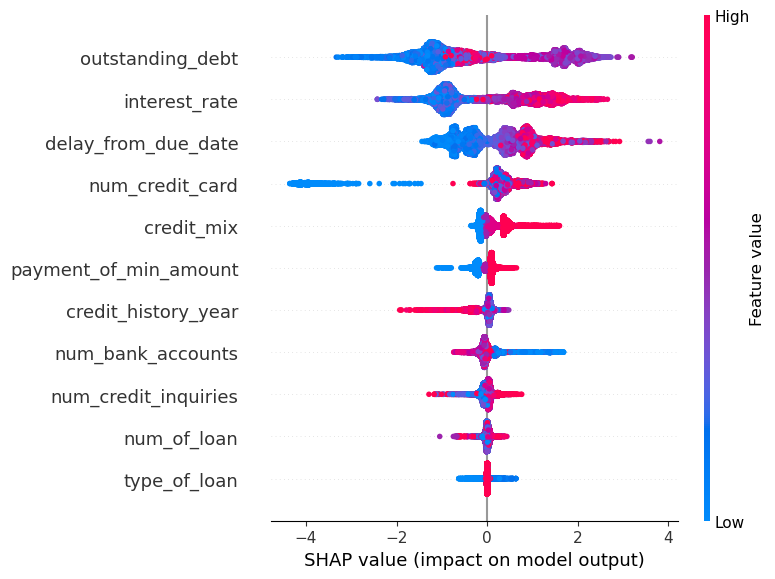

In [57]:
shap.summary_plot(shap_values_train,
                  pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp4])),
                  feature_names = transformed_feature_names,
                  max_display = 20
                  )

## 5.5) Exp 5 - Using Bayes Opt Hyper params

In [18]:
feats_exp4 = ['outstanding_debt','interest_rate','type_of_loan','delay_from_due_date','credit_mix','payment_of_min_amount','num_credit_inquiries',
              'credit_history_year','num_bank_accounts','num_of_loan','num_credit_card']

In [23]:
lgbm = LGBMClassifier(random_state=42,verbosity=-1)

models = [lgbm]

params_lgbm = [{
    'estimator__learning_rate': np.arange(0.05, 0.2, 0.08),
    'estimator__max_depth': np.arange(3, 6, 1),
    'estimator__num_leaves': np.arange(100, 250, 20),
    'estimator__n_estimators': np.arange(200, 400, 50),
    'estimator__min_child_samples': np.arange(200, 350, 50),
    'estimator__reg_lambda': np.arange(0.1, 4, 0.5),
    'estimator__reg_alpha': np.arange(0.1, 4, 0.5),
    'estimator__subsample': np.arange(0.7, 0.9, 0.08),
}]

params = [params_lgbm]

results = []

for model, parameter in zip(models, params):
    pipe = pipe_model.get_pipeline(X_train_te[feats_exp4], model).fit(X_train_te[feats_exp4], y_train_te)
    
    grid = BayesSearchCV(pipe,
                         search_spaces=parameter,
                         cv=10,
                         scoring='neg_log_loss',
                         n_jobs = -1,
                         refit = True,
                         verbose = 0,
                         n_iter=10,
                         random_state=42
    )
    
    grid.fit(X_train_te[feats_exp4],y_train_te)
    
    results.append(f'Model {model} \n best parameters: {grid.best_params_}\n best score avg: {grid.best_score_}\n\n')
    
    print(f'Model {model} \n best parameters: {grid.best_params_}\n best score avg: {grid.best_score_}\n\n')

Model LGBMClassifier(random_state=42, verbosity=-1) 
 best parameters: OrderedDict([('estimator__learning_rate', 0.11699106844426276), ('estimator__max_depth', 5), ('estimator__min_child_samples', 250), ('estimator__n_estimators', 350), ('estimator__num_leaves', 220), ('estimator__reg_alpha', 0.1), ('estimator__reg_lambda', 0.6), ('estimator__subsample', 0.7799999999999999)])
 best score avg: -0.24300085228443025




In [25]:
params = {
    'lgbm': {
        'learning_rate': 0.11699106844426276,
        'max_depth': 5,
        'num_leaves': 220,
        'n_estimators': 350,
        'min_child_samples': 250,
        'reg_lambda': 0.6,
        'reg_alpha': 0.1,
        'subsample': 0.7799999999999999
    }
}

In [26]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42, verbosity = -1, **params['lgbm'])]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train_te[feats_exp4], model).fit(X_train_te[feats_exp4], y_train_te)
    
    ks_train = eval.calculate_ks(X_train_te[feats_exp4], y_train_te, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos_te[feats_exp4], y_oos_te, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

Train KS: 0.829
OOS KS: 0.795


In [27]:
feature_importances = pipe.named_steps['estimator'].feature_importances_

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out(X_train_te[feats_exp4].columns)

transformed_feature_names = []

for var in feature_names:
    new_var_name = var[5:]
    transformed_feature_names.append(new_var_name)

In [28]:
explainer = shap.TreeExplainer(model)

shap_values_train = explainer.shap_values(pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp4])))

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


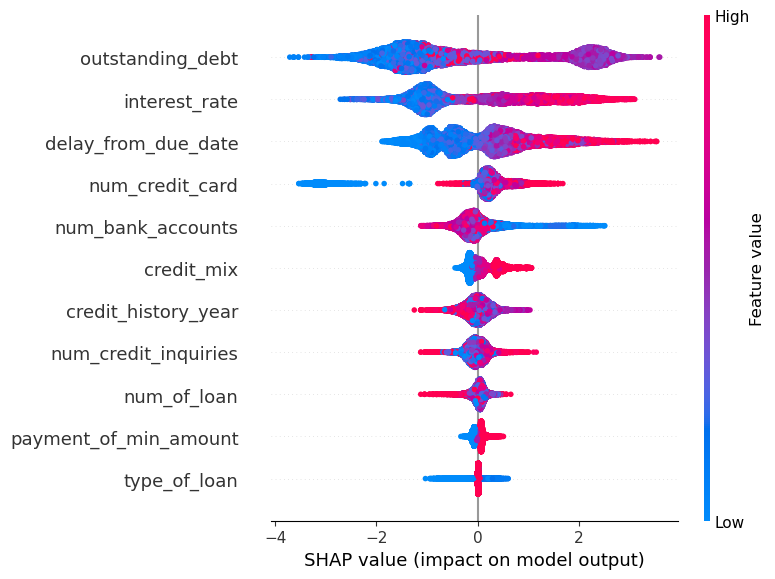

In [29]:
shap.summary_plot(shap_values_train,
                  pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp4])),
                  feature_names = transformed_feature_names,
                  max_display = 20
                  )

worst features: `type_of_loan`, `payment_of_min_amount`. By removing these features, the KS will not decrease a lot

## 5.6) Exp 6 - Removing the worst features of the SHAP

In [16]:
feats_exp6 = ['outstanding_debt','interest_rate','delay_from_due_date','credit_mix','num_credit_inquiries',
              'credit_history_year','num_bank_accounts','num_of_loan','num_credit_card']

In [17]:
params = {
    'lgbm': {
        'learning_rate': 0.11699106844426276,
        'max_depth': 5,
        'num_leaves': 220,
        'n_estimators': 350,
        'min_child_samples': 250,
        'reg_lambda': 0.6,
        'reg_alpha': 0.1,
        'subsample': 0.7799999999999999
    }
}

In [18]:
TARGET = 'target'

models = [LGBMClassifier(random_state = 42, verbosity = -1, **params['lgbm'])]

for model in models:
    
    pipe = pipe_model.get_pipeline(X_train_te[feats_exp6], model).fit(X_train_te[feats_exp6], y_train_te)
    
    ks_train = eval.calculate_ks(X_train_te[feats_exp6], y_train_te, pipe, TARGET) 
    ks_oos = eval.calculate_ks(X_oos_te[feats_exp6], y_oos_te, pipe, TARGET) 
    
    print(f'Train KS:', ks_train)
    print(f'OOS KS:', ks_oos)

Train KS: 0.831
OOS KS: 0.793


In [41]:
feature_importances = pipe.named_steps['estimator'].feature_importances_

feature_names = pipe.named_steps['preprocessor'].get_feature_names_out(X_train_te[feats_exp6].columns)

transformed_feature_names = []

for var in feature_names:
    new_var_name = var[5:]
    transformed_feature_names.append(new_var_name)

In [42]:
explainer = shap.TreeExplainer(model)

shap_values_train = explainer.shap_values(pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp6])))

C:\Users\lucas\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


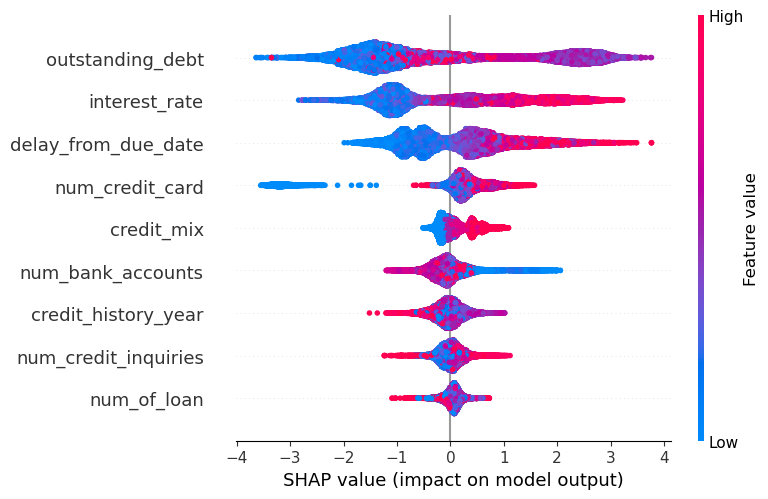

In [43]:
shap.summary_plot(shap_values_train,
                  pd.DataFrame(pipe['preprocessor'].fit_transform(X_train_te[feats_exp6])),
                  feature_names = transformed_feature_names,
                  max_display = 20
                  )

### Saving the winning model

In [52]:
import pickle

with open("../model_artifact/exp6_lgbm_classifier_iv_vars.pkl", "wb") as arquivo:
    pickle.dump(model, arquivo)


# 6) Evaluations

## 6.1) AUC Curve & Calibration Curve

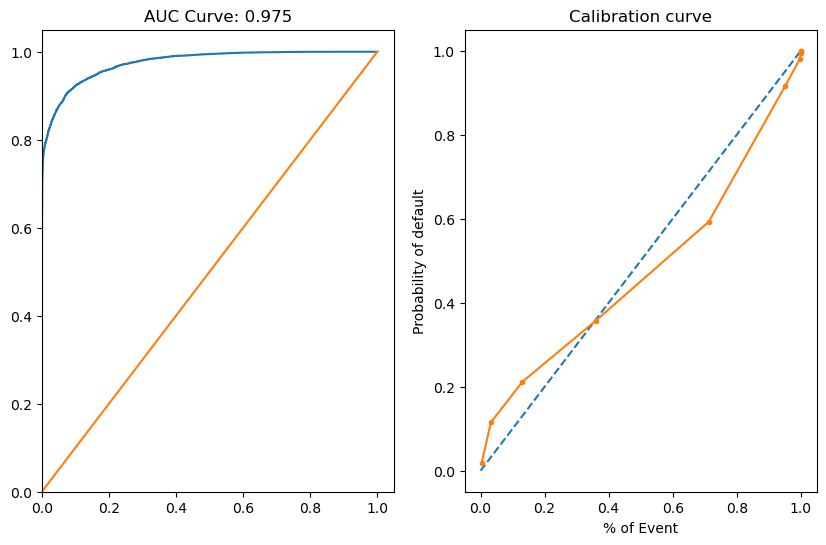

In [19]:
eval.Modelplots().generate_model_plots(x=X_train_te, y=y_train_te, pipeline=pipe)

## 6.2) KS per Month

In [23]:
df_ks = pd.DataFrame(columns=[
    'sample_type',
    'month',
    'bad_rate',
    'ks',
    'volumetry'
])

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Train

In [25]:
#Creating the ks dataset
df_ks_train = X_train_te[['month']+feats_exp6].copy()
df_ks_train['target'] = y_train_te

#Calculte the predict prob
df_ks_train['pred_prob'] = 1000*(pipe.predict_proba(df_ks_train)[:,1])
df_ks_train['pred_prob'] = 1000-df_ks_train['pred_prob']

list_of_dicts = []

for month in np.sort(df_ks_train['month'].unique()):
    
    tmp = df_ks_train[df_ks_train['month'] == month]
    ks = ks_2samp(tmp.loc[tmp['target'] == 0, 'pred_prob'],
                  tmp.loc[tmp['target'] == 1, 'pred_prob'])[0]
    
    bad = tmp['target'].mean()
    qtd = tmp.shape[0]
    
    aux_dict = {
                'sample_type':'train',
                'month':month,
                'bad_rate':bad,
                'ks':ks,
                'volumetry':qtd}
    
    list_of_dicts.append(aux_dict)
    
df_ks_clean_train = pd.DataFrame()
df_ks_clean_train = pd.DataFrame(list_of_dicts)

df_ks_clean_train

,sample_type,month,bad_rate,ks,volumetry
0,train,April,0.608,0.811,4826
1,train,August,0.594,0.773,4788
2,train,February,0.636,0.900,4411
3,train,January,0.641,0.901,4442
4,train,July,0.600,0.768,4828
5,train,June,0.612,0.808,4867
6,train,March,0.641,0.910,4432
7,train,May,0.621,0.812,4866


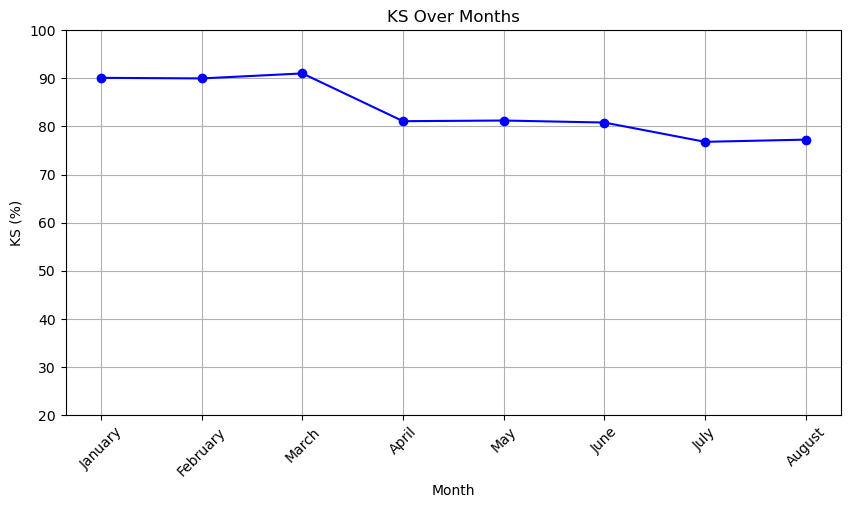

In [28]:
# month dict
month_order = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

# order months
df_ks_clean_train["month_order"] = df_ks_clean_train["month"].map(month_order)
df_ks_clean_train = df_ks_clean_train.sort_values("month_order")

# plot
plt.figure(figsize=(10, 5))
plt.plot(df_ks_clean_train["month"], df_ks_clean_train["ks"] * 100, marker='o', linestyle='-', color='b')

# Ajustes no gráfico
plt.xlabel("Month")
plt.ylabel("KS (%)")
plt.ylim(20, 100)
plt.title("KS Over Months")
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

### OOS

In [26]:
#Creating the ks dataset
df_ks_oos = X_oos_te[['month']+feats_exp6].copy()
df_ks_oos['target'] = y_oos_te

#Calculte the predict prob
df_ks_oos['pred_prob'] = 1000*(pipe.predict_proba(df_ks_oos)[:,1])
df_ks_oos['pred_prob'] = 1000-df_ks_oos['pred_prob']

list_of_dicts = []

for month in np.sort(df_ks_oos['month'].unique()):
    
    tmp = df_ks_oos[df_ks_oos['month'] == month]
    ks = ks_2samp(tmp.loc[tmp['target'] == 0, 'pred_prob'],
                  tmp.loc[tmp['target'] == 1, 'pred_prob'])[0]
    
    bad = tmp['target'].mean()
    qtd = tmp.shape[0]
    
    aux_dict = {
                'sample_type':'oos',
                'month':month,
                'bad_rate':bad,
                'ks':ks,
                'volumetry':qtd}
    
    list_of_dicts.append(aux_dict)
    
df_ks_clean_oos = pd.DataFrame()
df_ks_clean_oos = pd.DataFrame(list_of_dicts)

df_ks_clean_oos

,sample_type,month,bad_rate,ks,volumetry
0,oos,April,0.614,0.775,1201
1,oos,August,0.618,0.725,1227
2,oos,February,0.640,0.896,1144
3,oos,January,0.657,0.892,1115
4,oos,July,0.597,0.706,1197
5,oos,June,0.611,0.786,1223
6,oos,March,0.643,0.869,1103
7,oos,May,0.598,0.775,1156


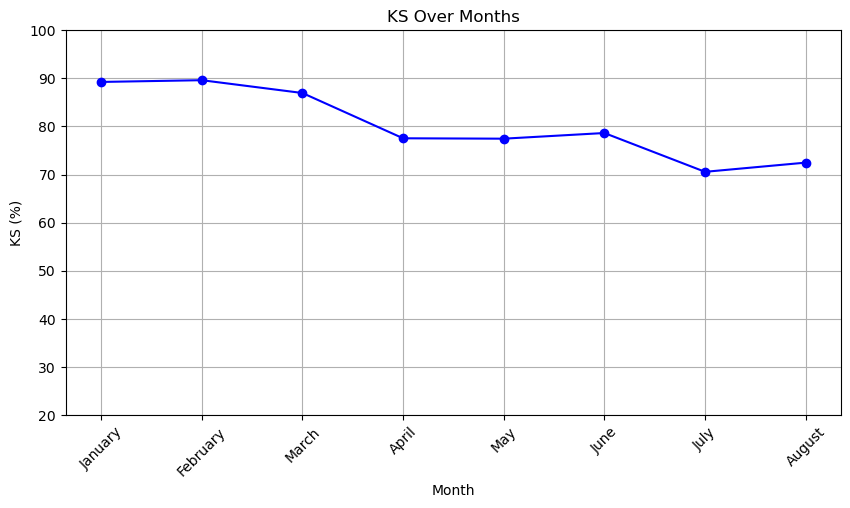

In [29]:
# month dict
month_order = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

# order months
df_ks_clean_oos["month_order"] = df_ks_clean_oos["month"].map(month_order)
df_ks_clean_oos = df_ks_clean_oos.sort_values("month_order")

# plot
plt.figure(figsize=(10, 5))
plt.plot(df_ks_clean_oos["month"], df_ks_clean_oos["ks"] * 100, marker='o', linestyle='-', color='b')

# Ajustes no gráfico
plt.xlabel("Month")
plt.ylabel("KS (%)")
plt.ylim(20, 100)
plt.title("KS Over Months")
plt.xticks(rotation=45)  
plt.grid(True)
plt.show()

## 6.3) Bins - Homogeneuos Groups

### Train

In [30]:
# Creating the dataset with predictions
aux_X = X_train_te[feats_exp6].copy()

aux_X['pred_prob'] = 1000*pipe.predict_proba(X_train_te[feats_exp6])[:,1]

aux_X['pred_prob'] = 1000-aux_X['pred_prob']

# Adding the target
aux_X['target'] = y_train_te

# Splitting the values
X = aux_X['pred_prob'].values
y = aux_X['target'].values

# creating the bins
optbin = OptimalBinning(
    name = 'pred_prob',
    dtype = 'numerical',
    solver = 'cp',
    max_n_prebins = 20,
    min_bin_size = 0.05,
    min_event_rate_diff = 0.015
)

optbin.fit(X,y)

binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 17.99)",13014,0.347,5,13009,1.000,-7.380,4.140,0.193
1,"[17.99, 148.13)",5165,0.138,94,5071,0.982,-3.504,0.744,0.063
2,"[148.13, 367.32)",1874,0.050,349,1525,0.814,-0.991,0.041,0.005
3,"[367.32, 525.04)",2028,0.054,628,1400,0.690,-0.318,0.005,0.001
4,"[525.04, 653.37)",2431,0.065,1364,1067,0.439,0.729,0.036,0.004
5,"[653.37, 731.36)",1898,0.051,1365,533,0.281,1.424,0.103,0.012
6,"[731.36, 808.33)",2243,0.060,1894,349,0.156,2.175,0.256,0.027
7,"[808.33, 880.64)",3014,0.080,2841,173,0.057,3.282,0.628,0.055
8,"[880.64, 940.05)",2389,0.064,2347,42,0.018,4.507,0.732,0.053
9,"[940.05, inf)",3404,0.091,3398,6,0.002,6.823,1.621,0.082


In [31]:
optbin.splits

array([ 17.99478817, 148.1335907 , 367.32455444, 525.04098511,
       653.3704834 , 731.36291504, 808.33175659, 880.6439209 ,
       940.0463562 ])

In [42]:
bins_opt = [0,17.99478817, 148.1335907 , 367.32455444, 525.04098511,
            653.3704834 , 731.36291504, 808.33175659, 880.6439209 ,
            1000]

labels_opt = [0,1,2,3,4,5,6,7,8]

# Applying in the train dataset
aux_X['gh'] = pd.cut(aux_X['pred_prob'], bins = bins_opt, labels = labels_opt)
aux_X['month'] = X_train_te['month']

c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wil

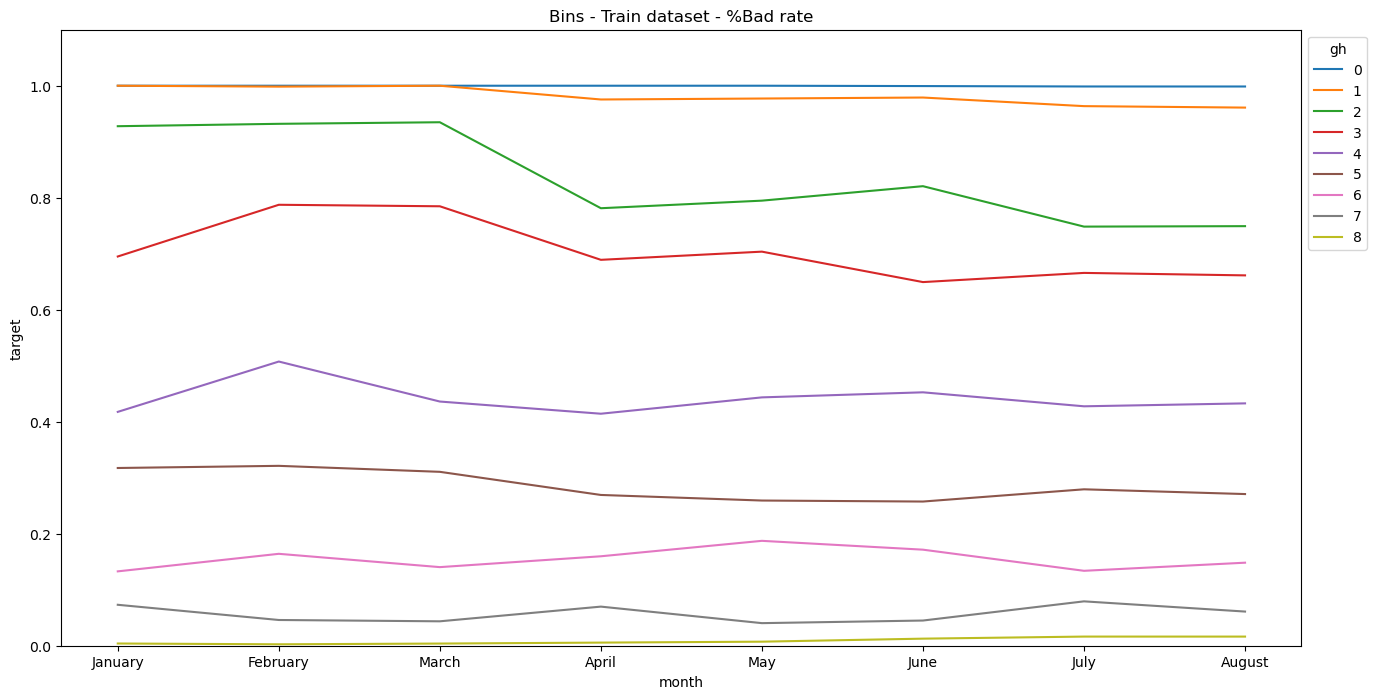

In [44]:
col_gh = 'gh'

fig, ax = plt.subplots(figsize=(16,8))

graph = sns.lineplot(
                    data = aux_X,
                    x = 'month',
                    y = 'target',
                    hue = col_gh,
                    ax=ax,
                    errorbar=None
)

sns.move_legend(graph, 'upper left', bbox_to_anchor=(1,1))

plt.title('Bins - Train dataset - %Bad rate')
plt.ylim(0,1.1)

plt.show()

In [47]:
dfgh_train = aux_X.groupby(['gh', 'target']).size().unstack(fill_value=0)
dfgh_train['vol'] = dfgh_train[0]+dfgh_train[1]
dfgh_train['bad_rate'] = (dfgh_train[1]/dfgh_train['vol'])*100
dfgh_train

C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\2576421806.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfgh_train = aux_X.groupby(['gh', 'target']).size().unstack(fill_value=0)


target,0,1,vol,bad_rate
gh,,,,
0,5,13009,13014,99.962
1,94,5071,5165,98.180
2,349,1525,1874,81.377
3,628,1400,2028,69.034
4,1364,1067,2431,43.891
5,1365,533,1898,28.082
6,1894,349,2243,15.560
7,2841,173,3014,5.740
8,5745,48,5793,0.829


### OOS

In [45]:
aux_oos = X_oos_te.copy()

aux_oos['pred_prob'] = 1000*pipe.predict_proba(X_oos_te[feats_exp6])[:,1]

aux_oos['pred_prob'] = 1000-aux_oos['pred_prob']

# Adding the target
aux_oos['target'] = y_oos_te

bins_opt = [0,17.99478817, 148.1335907 , 367.32455444, 525.04098511,
            653.3704834 , 731.36291504, 808.33175659, 880.6439209 ,
            1000]

labels_opt = [0,1,2,3,4,5,6,7,8]

# Applying in the train dataset
aux_oos['gh'] = pd.cut(aux_oos['pred_prob'], bins = bins_opt, labels = labels_opt)
aux_oos['month'] = X_oos_te['month']

c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\ProgramData\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wil

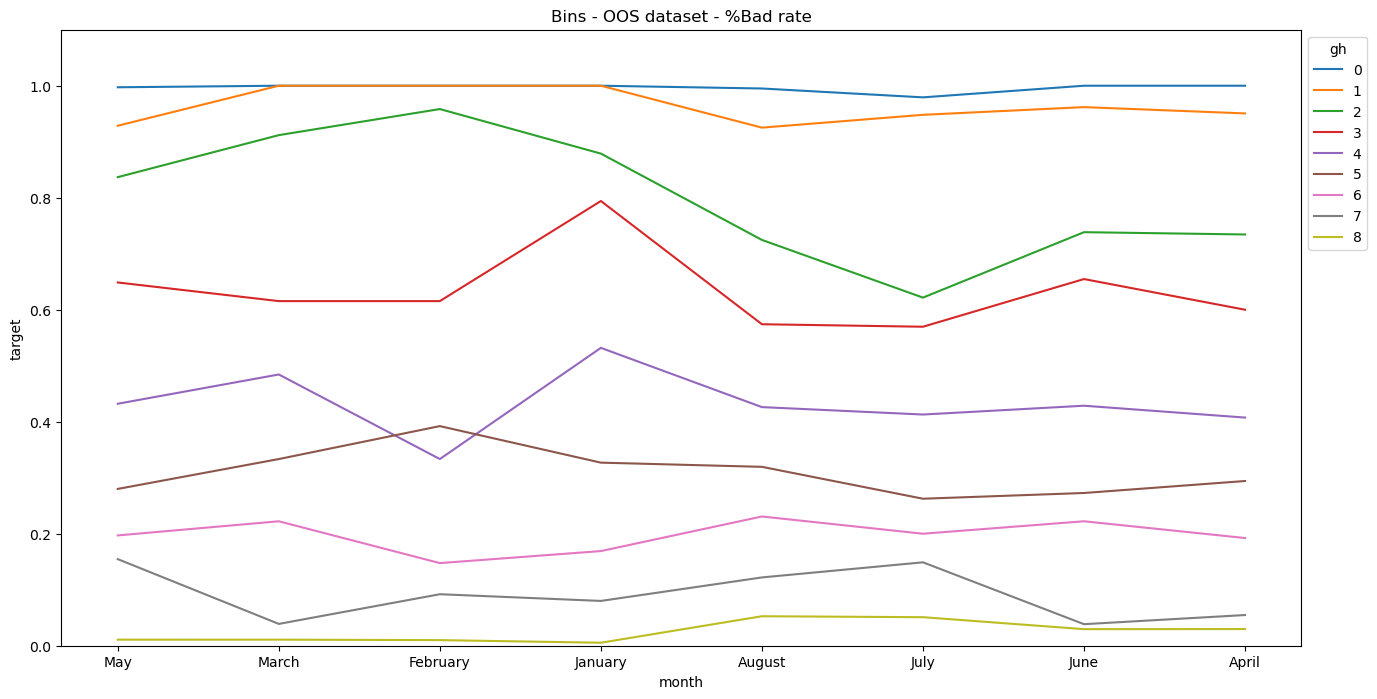

In [46]:
col_gh = 'gh'

fig, ax = plt.subplots(figsize=(16,8))

graph = sns.lineplot(
                    data = aux_oos,
                    x = 'month',
                    y = 'target',
                    hue = col_gh,
                    ax=ax,
                    errorbar=None
)

sns.move_legend(graph, 'upper left', bbox_to_anchor=(1,1))

plt.title('Bins - OOS dataset - %Bad rate')
plt.ylim(0,1.1)

plt.show()

In [48]:
dfgh_oos = aux_oos.groupby(['gh', 'target']).size().unstack(fill_value=0)
dfgh_oos['vol'] = dfgh_oos[0]+dfgh_oos[1]
dfgh_oos['bad_rate'] = (dfgh_oos[1]/dfgh_oos['vol'])*100
dfgh_oos

C:\Users\lucas\AppData\Local\Temp\ipykernel_5680\3765134420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfgh_oos = aux_oos.groupby(['gh', 'target']).size().unstack(fill_value=0)


target,0,1,vol,bad_rate
gh,,,,
0,11,3257,3268,99.663
1,46,1269,1315,96.502
2,97,315,412,76.456
3,202,330,532,62.030
4,379,283,662,42.749
5,370,162,532,30.451
6,444,110,554,19.856
7,625,64,689,9.289
8,1369,33,1402,2.354


# 7) Saving the scored datasets

## 7.1) Creating a copy

In [56]:
df_train_copy = df_train_te.copy()
df_oos_copy = df_oos_te.copy()

## 7.2) Creating the score

In [57]:
bins_opt = [0,17.99478817, 148.1335907 , 367.32455444, 525.04098511,
            653.3704834 , 731.36291504, 808.33175659, 880.6439209 ,
            1000]

labels_opt = [0,1,2,3,4,5,6,7,8]

# predicting...
df_train_copy['score_modelv6'] = 1000*pipe.predict_proba(df_train_copy[feats_exp6])[:,1]
df_train_copy['score_modelv6'] = 1000-df_train_copy['score_modelv6']

df_oos_copy['score_modelv6'] = 1000*pipe.predict_proba(df_oos_copy[feats_exp6])[:,1]
df_oos_copy['score_modelv6'] = 1000-df_oos_copy['score_modelv6']

# creating the bins...
df_train_copy['gh'] = pd.cut(df_train_copy['score_modelv6'], bins = bins_opt, labels = labels_opt)
df_oos_copy['gh'] = pd.cut(df_oos_copy['score_modelv6'], bins = bins_opt, labels = labels_opt)

## 7.3) Saving...

In [60]:
df_train_copy.to_csv('../data/train_scored.csv')
df_oos_copy.to_csv('../data/oos_scored.csv')